# Importowanie bibliotek

In [24]:
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from collections import defaultdict
import time

# Klasyfikator rangowy

In [16]:
class LinesClassificator:
    
    def __init__(self):
        self.possible_splits_dict = None
        self.is_split_dict = None
        self.rewards = None
        self.splits = []

    
    def remove_duplicates(self, df):
        grouped = df.groupby(df.columns[:-1].tolist())
        cleaned_rows = []

        for _, group_data in grouped:
            most_frequent_label = group_data[df.columns[-1]].mode().iloc[0]
            group_data[df.columns[-1]] = most_frequent_label
            cleaned_rows.append(group_data)

        cleaned_df = pd.concat(cleaned_rows, ignore_index=True)
        return cleaned_df
    

    def drawLines(self, df):
        fig, ax = plt.subplots()
        unique_classes = df['class'].unique()
        colors = plt.cm.rainbow_r(np.linspace(0, 1, len(unique_classes)))
        for i, class_label in enumerate(unique_classes):
            class_data = df[df['class'] == class_label]
            ax.scatter(x=class_data[df.columns[0]], y=class_data[df.columns[1]], label=class_label, color=colors[i])
        ax.legend()
        plt.xlabel(df.columns[0])
        plt.ylabel(df.columns[1])
        for split in self.splits:
            column = split[0]
            value = split[1]
            if column == 0:
                plt.axvline(x=value, color='blue', linestyle='--')
            if column == 1:
                plt.axhline(y=value, color='red', linestyle='--') 
             
        plt.show()
    

    def calculate_mistakes(self, df):
        classes = df['class']
        class_counts = defaultdict(int)

        for c in classes:
            class_counts[c] += 1
        
        n = len(df)

        same_class_pairs_sum = sum((count * (count - 1)) / 2 for count in class_counts.values())
        all_pairs_sum = (n * (n-1))/2
        mistakes = all_pairs_sum - same_class_pairs_sum
        
        return mistakes


    def find_best_cut(self, df, mistakes):
        best_dimension = None
        best_threshold = None
        best_mistakes = mistakes

        dimensions = len(df.columns) - 2
        
        for dimension in range(dimensions):
            data = df.sort_values(by = df.columns[dimension])

            data['midpoint'] = (data[data.columns[dimension]].shift(-1) + data[data.columns[dimension]]) / 2
            data['midpoint'] = data['midpoint'].fillna(data.iloc[-1][data.columns[dimension]])

            data['left_count_by_binary_and_class'] = data.groupby(['binary', 'class']).cumcount().values
            data['left_count_by_binary'] = data.groupby('binary').cumcount().values
            data['right_count_by_binary_and_class'] = data.groupby(['binary', 'class']).cumcount(ascending=False).values
            data['right_count_by_binary'] = data.groupby('binary').cumcount(ascending=False).values
            data['delta_mistakes'] = data['left_count_by_binary'] - data['left_count_by_binary_and_class'] - data['right_count_by_binary'] + data['right_count_by_binary_and_class']
            data['total_delta_mistakes'] = data['delta_mistakes'].cumsum()

            data = data.drop_duplicates(subset=[df.columns[dimension]], keep='last')
            best_row = data.nsmallest(1, 'total_delta_mistakes', keep='first')
            
            actual_mistakes = mistakes + best_row['total_delta_mistakes'].iat[0]

            if actual_mistakes < best_mistakes:
                best_mistakes = actual_mistakes
                best_dimension = dimension
                best_threshold = best_row['midpoint'].iat[0]

        return best_dimension, best_threshold, best_mistakes

    
    def fit(self, df):
        cleaned = self.remove_duplicates(df)
        cleaned.columns = [*cleaned.columns[:-1], 'class']
        cleaned['binary'] = ''

        mistakes = self.calculate_mistakes(cleaned)
        print(mistakes)

        start_loop_time = time.time()
        while mistakes > 0:
            
            dimension, threshold, mistakes = self.find_best_cut(cleaned, mistakes)
            print(dimension, threshold, mistakes)
            self.splits.append((dimension, threshold, mistakes))
            
            suffixes = cleaned[cleaned.columns[dimension]].apply(lambda x: '1' if x > threshold else '0')
            cleaned['binary'] = cleaned['binary'] + suffixes
        end_loop_time = time.time()

        print('Execution time: ', end_loop_time -start_loop_time, 'seconds')
        print("Number of cuts: ", len(self.splits))
        print("Dropped points: ", len(df) - len(cleaned))

        print(cleaned)
        cleaned.to_csv('output_lines.csv', index=False)

        if len(df.columns) - 1 == 2:
            self.drawLines(cleaned)

        return cleaned

    

    def predict(self, predict_df):
        predictions = []

        for split in self.splits:
            column = split[0]
            value = split[1]
            predictions.append((predict_df[predict_df.columns[column]] > value).astype(int).astype(str))

        return [''.join(binary) for binary in zip(*predictions)]

lines_classifier = LinesClassificator()

# Projekcja danych irys

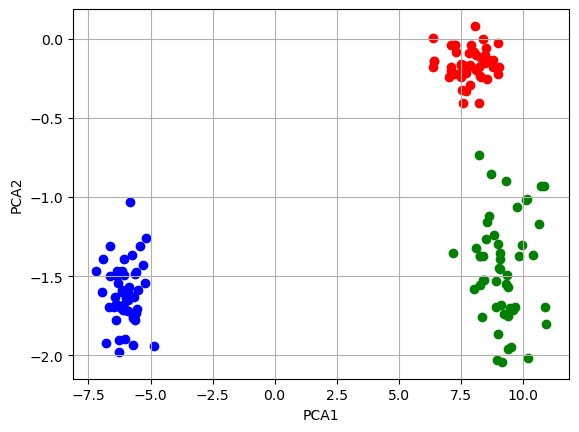

In [14]:
iris = datasets.load_iris()
df = pd.DataFrame(iris.data)
df['target'] = iris.target

def project_data(df):

    covariance_matrix = df.cov()
    values, vectors = np.linalg.eig(covariance_matrix)
    top_vectors = vectors[:, :2]
    projected = df.dot(top_vectors)
    return projected
    
X_0 = df[df['target'] == 0].drop(columns = ['target'])
X_1 = df[df['target'] == 1].drop(columns = ['target'])
X_2 = df[df['target'] == 2].drop(columns = ['target'])

X_0 = project_data(X_0)
X_1 = project_data(X_1)
X_2 = project_data(X_2)

X = pd.concat([X_0, X_1, X_2])

plt.scatter(X_0[0], X_0[1], color='blue')
plt.scatter(X_1[0], X_1[1], color='red')
plt.scatter(X_2[0], X_2[1], color='green')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid()
plt.show()

In [20]:
X['class'] =  [0]*50 + [1]*50 + [2]*50
X

,0,1,class
0,-6.129691,-1.589117,0
1,-5.628802,-1.779877,0
2,-5.632161,-1.487160,0
3,-5.511147,-1.587450,0
4,-6.136198,-1.467261,0
...,...,...,...
145,9.124394,-1.682032,2
146,8.551256,-1.159984,2
147,8.939059,-1.529297,2
148,8.960779,-2.030233,2


7500.0
0 0.7634411459223145 2500.0
1 -0.5712686776899356 0.0
Execution time:  0.06499934196472168 seconds
Number of cuts:  2
Dropped points:  0
             0         1  class binary
0    -7.214239 -1.464434      0     00
1    -6.945811 -1.599288      0     00
2    -6.911226 -1.393799      0     00
3    -6.786702 -1.921756      0     00
4    -6.665750 -1.693417      0     00
..         ...       ...    ...    ...
145  10.645603 -1.172242      2     10
146  10.729459 -0.927116      2     10
147  10.851512 -0.929288      2     10
148  10.892582 -1.693535      2     10
149  10.957501 -1.799616      2     10

[150 rows x 4 columns]


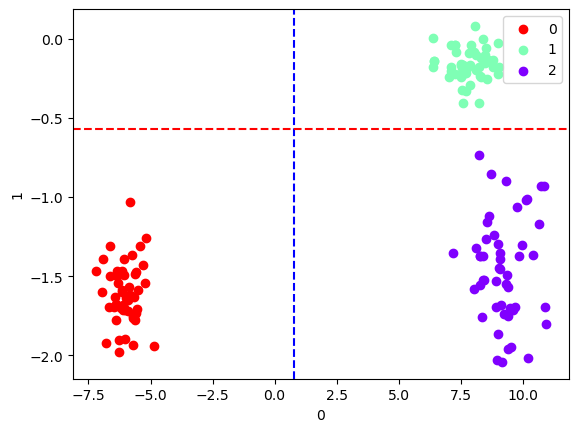

,0,1,class,binary
0,-7.214239,-1.464434,0,00
1,-6.945811,-1.599288,0,00
2,-6.911226,-1.393799,0,00
3,-6.786702,-1.921756,0,00
4,-6.665750,-1.693417,0,00
...,...,...,...,...
145,10.645603,-1.172242,2,10
146,10.729459,-0.927116,2,10
147,10.851512,-0.929288,2,10
148,10.892582,-1.693535,2,10


In [25]:
lines_classifier.fit(X)

# Inne zbiory danych

In [32]:
columns = ['x', 'y', 'class']

16.0
1 1.5 5.0
0 1.5 1.0
1 0.5 0.0
Execution time:  0.0780177116394043 seconds
Number of cuts:  3
Dropped points:  0
   x  y class binary
0  0  0     A    000
1  0  1     C    001
2  0  3     B    101
3  1  2     B    101
4  2  0     A    010
5  2  2     C    111
6  3  1     A    011


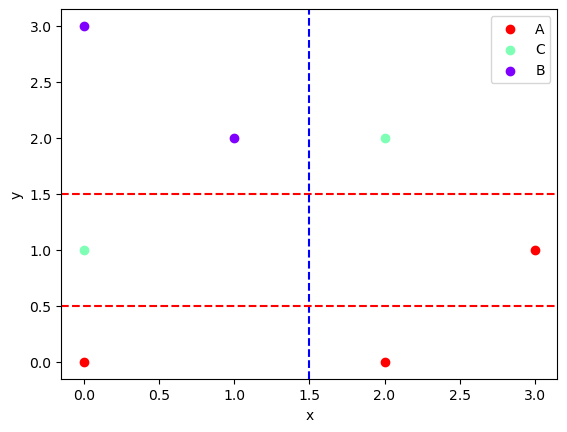

,x,y,class,binary
0,0,0,A,000
1,0,1,C,001
2,0,3,B,101
3,1,2,B,101
4,2,0,A,010
5,2,2,C,111
6,3,1,A,011


In [34]:
data1 = [
    [0, 0, 'A'],
    [2, 0, 'A'],
    [0, 1, 'C'],
    [3, 1, 'A'],
    [1, 2, 'B'],
    [2, 2, 'C'],
    [0, 3, 'B']
]

df1 = pd.DataFrame(data=data1, columns=columns)
lines_classifier = LinesClassificator()
lines_classifier.fit(df1)

9.0
1 0.5 4.0
0 0.5 0.0
Execution time:  0.06799745559692383 seconds
Number of cuts:  2
Dropped points:  0
   x  y class binary
0  0  0     A     00
1  0  1     B     10
2  1  0     B     01
3  1  1     A     11
4  2  0     B     01
5  2  1     A     11


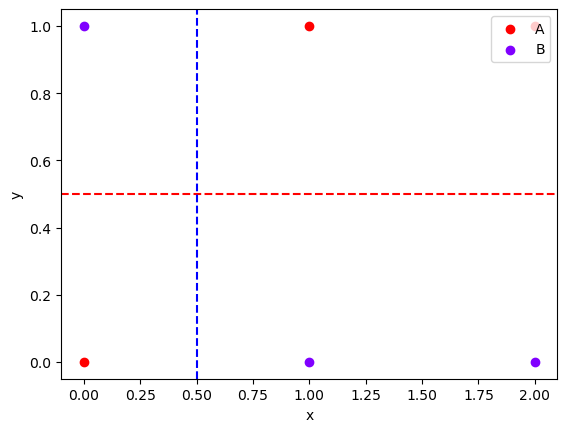

,x,y,class,binary
0,0,0,A,00
1,0,1,B,10
2,1,0,B,01
3,1,1,A,11
4,2,0,B,01
5,2,1,A,11


In [35]:
data2 = [
    [0,0,'A'],
    [1,0,'B'],
    [2,0,'B'],
    [0,1,'B'],
    [1,1,'A'],
    [2,1,'A']
]


df2 = pd.DataFrame(data=data2, columns=columns)
lines_classifier = LinesClassificator()
lines_classifier.fit(df2)

5.0
0 1.5 2.0
1 0.5 0.0
Execution time:  0.06699562072753906 seconds
Number of cuts:  2
Dropped points:  0
   x  y class binary
0  0  0     C     00
1  1  1     B     01
2  2  1     C     11
3  3  0     A     10


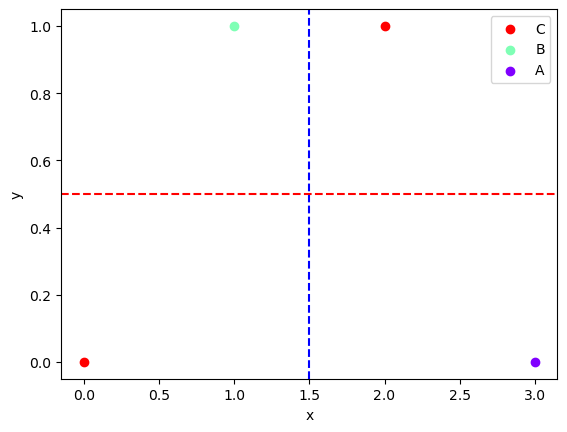

,x,y,class,binary
0,0,0,C,00
1,1,1,B,01
2,2,1,C,11
3,3,0,A,10


In [36]:
data3 = [
    [0,0,'C'],
    [3,0,'A'],
    [1,1,'B'],
    [2,1,'C']
]


df3 = pd.DataFrame(data=data3, columns=columns)
lines_classifier = LinesClassificator()
lines_classifier.fit(df3)


4.0
0 3.5 0.0
Execution time:  0.0429997444152832 seconds
Number of cuts:  1
Dropped points:  0
   x  y class binary
0  0  0     A      0
1  1  0     A      0
2  2  0     A      0
3  3  0     A      0
4  4  0     B      1


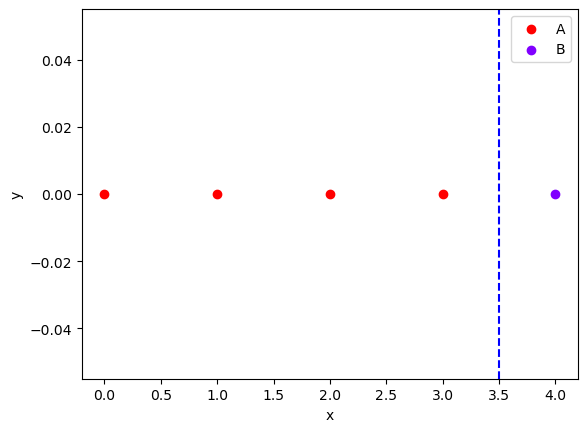

,x,y,class,binary
0,0,0,A,0
1,1,0,A,0
2,2,0,A,0
3,3,0,A,0
4,4,0,B,1


In [37]:
data4 = [
        [0,0,'A'],
        [1,0,'A'],
        [2,0,'A'],
        [3,0,'A'],
        [4,0,'B']
]


df4 = pd.DataFrame(data=data4, columns=columns)
lines_classifier = LinesClassificator()
lines_classifier.fit(df4)




64.0
0 1.5 32.0
1 1.5 16.0
0 0.5 12.0
0 2.5 8.0
1 0.5 4.0
1 2.5 0.0
Execution time:  0.15700626373291016 seconds
Number of cuts:  6
Dropped points:  0
    x  y class  binary
0   0  0     A  000000
1   0  1     B  000010
2   0  2     B  010010
3   0  3     A  010011
4   1  0     B  001000
5   1  1     A  001010
6   1  2     A  011010
7   1  3     B  011011
8   2  0     B  101000
9   2  1     A  101010
10  2  2     A  111010
11  2  3     B  111011
12  3  0     A  101100
13  3  1     B  101110
14  3  2     B  111110
15  3  3     A  111111


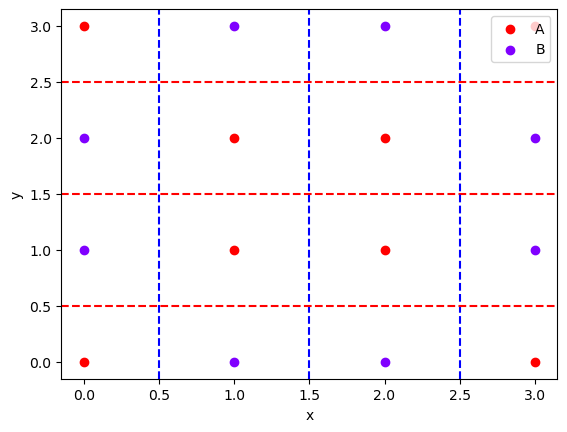

,x,y,class,binary
0,0,0,A,000000
1,0,1,B,000010
2,0,2,B,010010
3,0,3,A,010011
4,1,0,B,001000
5,1,1,A,001010
6,1,2,A,011010
7,1,3,B,011011
8,2,0,B,101000
9,2,1,A,101010


In [38]:
data5 = [
    [0,0,'A'],
    [1,0,'B'],
    [2,0,'B'],
    [3,0,'A'],
    [0,1,'B'],
    [1,1,'A'],
    [2,1,'A'],
    [3,1,'B'],
    [0,2,'B'],
    [1,2,'A'],
    [2,2,'A'],
    [3,2,'B'],
    [0,3,'A'],
    [1,3,'B'],
    [2,3,'B'],
    [3,3,'A']   
]


df5 = pd.DataFrame(data=data5, columns=columns)
lines_classifier = LinesClassificator()
lines_classifier.fit(df5)


11.0
0 2.5 5.0
1 0.5 2.0
1 1.5 0.0
Execution time:  0.09698176383972168 seconds
Number of cuts:  3
Dropped points:  0
   x  y class binary
0  0  2     A    011
1  1  0     C    000
2  2  1     B    010
3  3  1     C    110
4  4  0     A    100
5  5  3     A    111


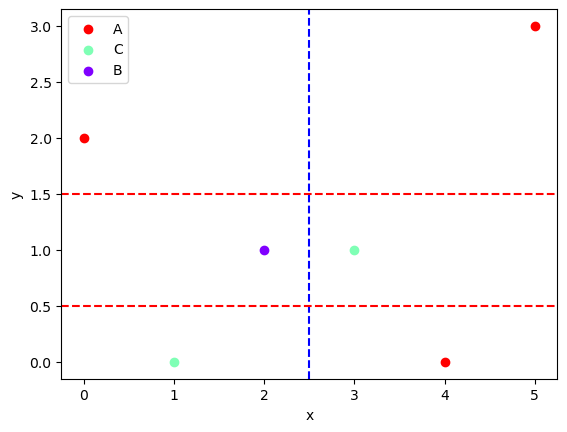

,x,y,class,binary
0,0,2,A,011
1,1,0,C,000
2,2,1,B,010
3,3,1,C,110
4,4,0,A,100
5,5,3,A,111


In [39]:
data6 = [
        [1,0,'C'],
        [4,0,'A'],
        [2,1,'B'],
        [3,1,'C'],
        [0,2,'A'],
        [5,3,'A']
]

df6 = pd.DataFrame(data=data6, columns=columns)
lines_classifier = LinesClassificator()
lines_classifier.fit(df6)


4.0
0 0.5 2.0
0 2.5 0.0
Execution time:  0.06700634956359863 seconds
Number of cuts:  2
Dropped points:  0
   x  y class binary
0  0  0     A     00
1  1  3     B     10
2  2  1     B     10
3  3  2     A     11


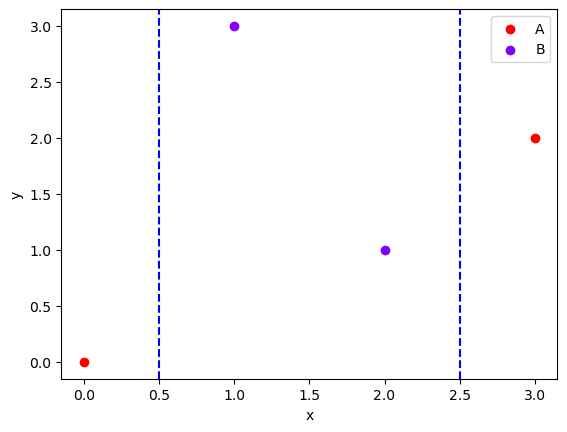

,x,y,class,binary
0,0,0,A,00
1,1,3,B,10
2,2,1,B,10
3,3,2,A,11


In [40]:
data7 = [
        [0,0,'A'],
        [2,1,'B'],
        [1,3,'B'],
        [3,2,'A']
]

df7 = pd.DataFrame(data=data7, columns=columns)
lines_classifier = LinesClassificator()
lines_classifier.fit(df7)




36.0
1 1.5 10.0
0 0.5 3.0
0 1.5 1.0
1 0.5 0.0
Execution time:  0.10801243782043457 seconds
Number of cuts:  4
Dropped points:  0
    x  y class binary
0   0  0     A   0000
1   0  1     A   0001
2   0  2     A   1001
3   1  0     A   0100
4   1  1     A   0101
5   1  2     B   1101
6   1  3     B   1101
7   2  0     A   0110
8   2  1     B   0111
9   2  2     B   1111
10  2  3     B   1111
11  3  3     B   1111


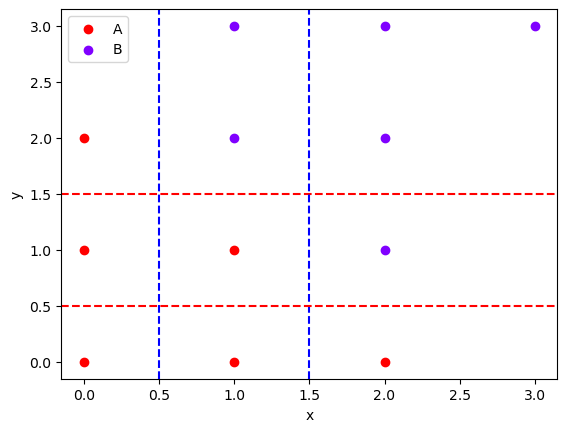

,x,y,class,binary
0,0,0,A,0000
1,0,1,A,0001
2,0,2,A,1001
3,1,0,A,0100
4,1,1,A,0101
5,1,2,B,1101
6,1,3,B,1101
7,2,0,A,0110
8,2,1,B,0111
9,2,2,B,1111


In [43]:
data8 = [
        [0,0,'A'],
        [1,0,'A'],
        [2,0,'A'],
        [0,1,'A'],
        [1,1,'A'],
        [2,1,'B'],
        [0,2,'A'],
        [1,2,'B'],
        [2,2,'B'],
        [1,3,'B'],
        [2,3,'B'],
        [3,3,'B']
]

df8 = pd.DataFrame(data=data8, columns=columns)
lines_classifier = LinesClassificator()
lines_classifier.fit(df8)


36.0
0 2.5 0.0
Execution time:  0.029994726181030273 seconds
Number of cuts:  1
Dropped points:  0
    x  y class binary
0   0  0     A      0
1   1  0     A      0
2   1  1     A      0
3   2  0     A      0
4   2  1     A      0
5   2  2     A      0
6   3  1     B      1
7   3  2     B      1
8   3  3     B      1
9   4  2     B      1
10  4  3     B      1
11  5  3     B      1


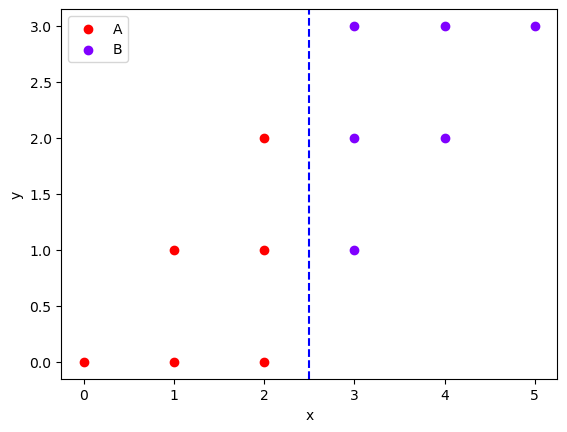

,x,y,class,binary
0,0,0,A,0
1,1,0,A,0
2,1,1,A,0
3,2,0,A,0
4,2,1,A,0
5,2,2,A,0
6,3,1,B,1
7,3,2,B,1
8,3,3,B,1
9,4,2,B,1


In [45]:
data9 = [
    [0,0,'A'],
    [1,0,'A'],
    [2,0,'A'],
    [1,1,'A'],
    [2,1,'A'],
    [3,1,'B'],
    [2,2,'A'],
    [3,2,'B'],
    [4,2,'B'],
    [3,3,'B'],
    [4,3,'B'],
    [5,3,'B']    

]

df9 = pd.DataFrame(data=data9, columns=columns)
lines_classifier = LinesClassificator()
lines_classifier.fit(df9)



33.0
0 -10.25 16.0
1 47.89 5.0
0 -19.795 2.0
0 79.325 0.0
Execution time:  0.11300063133239746 seconds
Number of cuts:  4
Dropped points:  0
       x      y class binary
0 -66.47  75.98     B   0100
1 -26.31  61.76     B   0100
2 -20.57 -66.91     C   0000
3 -19.02 -99.11     A   0010
4 -16.90  98.65     A   0110
5  -3.60 -76.51     B   1010
6  13.48  64.72     C   1110
7  37.52  72.83     C   1110
8  72.67  34.02     B   1010
9  85.98 -43.60     A   1011


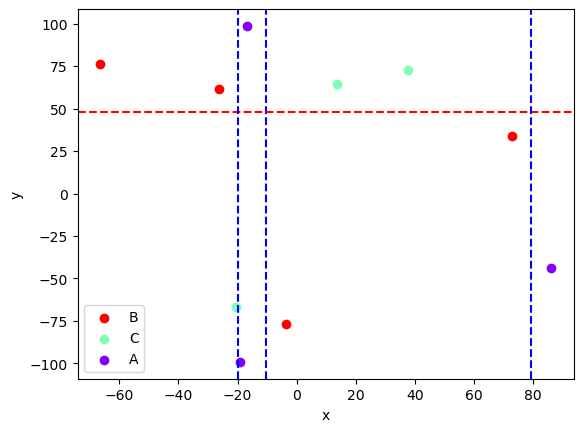

,x,y,class,binary
0,-66.47,75.98,B,0100
1,-26.31,61.76,B,0100
2,-20.57,-66.91,C,0000
3,-19.02,-99.11,A,0010
4,-16.90,98.65,A,0110
5,-3.60,-76.51,B,1010
6,13.48,64.72,C,1110
7,37.52,72.83,C,1110
8,72.67,34.02,B,1010
9,85.98,-43.60,A,1011


In [46]:
data10 = [
        [-3.6,-76.51,'B'],
        [-66.47,75.98,'B'],
        [-19.02,-99.11,'A'],
        [37.52,72.83,'C'],
        [-20.57,-66.91,'C'],
        [-26.31,61.76,'B'],
        [13.48,64.72,'C'],
        [72.67,34.02,'B'],
        [-16.9,98.65,'A'],
        [85.98,-43.6,'A'],

]

df10 = pd.DataFrame(data=data10, columns=columns)
lines_classifier = LinesClassificator()
lines_classifier.fit(df10)



